# Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neuronal Activity

## Romain Brette and Wulfram Gerstner, 2005

### Presentation and simulation by Louis, Linda and Hector (Master's students at ENS, Paris) 2020

In [1]:
import brian2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 7)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

title_fontsize = 36
ax_fontsize = 28
label_fontsize = 20

# 1. Theory

## A. aEIF model

Trying to go beyong the tradition LIF model : quadratic or exponential, inclusion of subthreshold resonances (adaptation), change the stimulation paradigm from current injection to conductance injection (closer to in vivo conditions).

We introduce the aEIF model :

$$C \frac{dV}{dt} =f(V) - w + I $$
$$ r = h(I) $$

where C is the membrane capacitance, f(V) is a function that cjracterizes the passive properties and the spiking mechanism, w is an adaptaion variable, and I is the synaptic current.

And $$ f(V) = - g_L (V - E_L) + g_L \Delta_T exp(\frac{V - V_T}{\Delta_T}) $$

where $g_l$ is th eleak conductance, $E_L$ is the resting potential,$\Delta_T$ is the slope factr, and $V_T$ is the threshold potential.

At spike time (when $V > V_{peak} = 20 mV$), $ V \mapsto E_L $ and $ w \mapsto w + b $

The adaptation current w is defined by:

$$\tau_w \frac{dw}{dt} =a (V - E_L) - w$$

where $\tau_w$ is the time constant and $a$ represents the level of subthreshold adaptation.

Finally, the current $I$ is given by :

   $$I = I_{AMPA} + I_{GABA} + I_{ext} + I_{noise}$$
   
   Where $ I_{AMPA} $ in an AMPA-dependent excitatory current, $ I_{GABA} $ is a GABA-dependent inhibitory current, $ I_{ext} $ is the injected current, and $ I_{noise} $ a random Gaussian number.
   
   Furthermore, we have : 
   
   $$I_{AMPA} = - g_e(t)(V - E_e) $$
   
  $$ I_{GABA} = -g_i(t)(V - E_i)$$
   
   Where $ E_e $ and $ E_i $ are the reversal potentials for the AMPA and GABA currents (respectively). $ g_e(t) $ and  $ g_i(t) $ are respectively the AMPA and GABA conductances and are described by Ornstein-Uhlenbeck processes with respective time constants $ t_e = 2.728 ms $ and $ t_i = 10.49 ms $. 
   
   As laid out in Destexhe et al., 2001 :
$$ \frac{dg_e(t)}{dt} = - \frac{1}{\tau_e}[g_e(t) - g_{e0}] + \sqrt{D_e}\chi_1(t)$$
 $$   \frac{dg_i(t)}{dt} = - \frac{1}{\tau_i}[g_i(t) - g_{i0}] + \sqrt{D_i}\chi_2(t) $$
    
Where $g_{e0} $ and $ g_{i0}$ are average conductances (the mean conductances given in Table 1, simply named $g_e$ and $g_i$ in the Brette & Gerstner), $D_e$ and $D_i$ are noise 'diffusion' coefficients, and $\chi_1(t)$ and $\chi_2(t)$ are Gaussian white noise of zero mean and unit standard deviation.

The update rule for those processes is given by
$$g_e(t+h) = g_{e0} + [g_e(t) - g_{e0}]exp(-\frac{h}{\tau_e}) + A_eN_1(0,1)$$
   $$g_i(t+h) = g_{i0} + [g_i(t) - g_{i0}]exp(-\frac{h}{\tau_i}) + A_iN_2(0,1) $$
   
$ N_i(0, 1) $ and $ N_2(0, 1) $ are normal random numbers (zero mean, unit SD). $ A_e $ and $A_i$ are amplitude coefficients given by :

$$ A_e = \sqrt{\frac{D_e\tau_e}{2}[1-exp(\frac{-2h}{\tau_e})]} $$
  $$  A_i = \sqrt{\frac{D_i\tau_i}{2}[1-exp(\frac{-2h}{\tau_i})]}$$

Finally, the diffusion coefficients are given by :
$$D = \frac{2\sigma^2}{\tau}$$

Taking all of this into account, we can define the following functions : 

In [2]:
def V_deriv(V_prev,w_now,input_current,parameters):
    
    V_new = (1/parameters['C_aEIF'])*(potential_to_current(V_prev, parameters) - w_now + input_current)
    return V_new

def potential_to_current(V, parameters):
    return - parameters['g_L_aEIF']*(V - parameters['E_L_aEIF']) + parameters['g_L_aEIF']*parameters['Delta_T']*np.exp((V - parameters['V_T'])/parameters['Delta_T'])

def w_deriv(w_prev,V_now,parameters):
    
    w_new = (1/parameters['tau_w'])*(parameters['a']*(V_now - parameters['E_L']) - w_prev)
    return w_new

def diff_coeff(sigma, tau):
    return (2*sigma**2)/tau

def amp_coeff(diff_coeff, tau, dt):
    return np.sqrt( ((diff_coeff*tau)/2) * (1-np.exp((-2*dt)/tau)))

def updt_g(g_prev, g_type, parameters,random_AMPA,random_GABA):
    
    if g_type =='AMPA':
        g_new = parameters['g_AMPA'] + (g_prev - parameters['g_AMPA'])*np.exp(-parameters['dt']/parameters['tau_AMPA']) \
        + parameters['A_AMPA']*random_AMPA
        
    elif g_type == 'GABA':
        g_new = parameters['g_GABA'] + (g_prev - parameters['g_GABA'])*np.exp(-parameters['dt']/parameters['tau_GABA']) \
        + parameters['A_GABA']*random_GABA
    
    else :
        raise ValueError('g_type must be either AMPA or GABA')
    
    return g_new



## B. Reference model.

(All of this comes from a chain of references : Brette & Gerstner 2005 --> (Destexhe et al. 1998 + (Destexhe et al. 2001 --> Destexhe and Paré, 1999 = **where all the useful equations are**))


The reference model is a single-compartment, Hodgkin & Huxley type model of a regular spiking pyramidal cell with voltage dependent currents $ I_M $, $ I_{Na} $ and $I_K$, which are respectively :
- a voltage-dependent $Na^{+}$ current ;
- a delayed-rectifier $K^+$ current ;
- a non-inactivating $K^+$ current responsible for spike frequency adaptation. 

$I_{Na}$ and $I_K$ are described by Traub & Miles, 1991, while $I_M$ is described by Destexhe and Paré, 1999.

This model is described by the following equations, taken from Destexhe et al., 2001 : 

\begin{align*}
& C_m\frac{dV}{dt} = -g_L(V-E_L)-I_{Na}-I_K-I_M-\frac{1}{a}I_{syn}  \\
& \\
& I_{Na} = \bar{g}_{Na}m^{3}h(V-E_{Na}) \\
& \\
& I_{K} = \bar{g}_{K}n^{4}(V-E_{K}) \\
& \\
& I_{M} = \bar{g}_{M}p(V-E_{K}) \\
\end{align*}

Where $C_m$ is the membrane capacitance, $g_L$ the leak conductance density, $E_L$ the leak reversal potential, $a$ is the total membrane area.

$m$ is a gating variable representing an activation gate, while $h$, $n$ and $p$ are gating variables representing inactivation gates. Those variables are described by differential equations, which leads to a total set of 5 differential equations to describe the model :

\begin{align*}
& C_m\frac{dV}{dt} = -g_L(V-E_L)-I_{Na}-I_K-I_M-\frac{1}{a}I_{syn}  \\
& \\
& \frac{dm}{dt} = \alpha_m(V)(1-m)-\beta_m(V)m \\
& \\
& \frac{dh}{dt} = \alpha_h(V)(1-h)-\beta_h(V)h \\
& \\
& \frac{dn}{dt} = \alpha_n(V)(1-n)-\beta_n(V)n \\
& \\
& \frac{dp}{dt} = \alpha_p(V)(1-p)-\beta_p(V)p \\
\end{align*}



Where, from Destexhe and Paré 1999 + the actual code from Destexhe 1998: 
\begin{align*}
& \alpha_m = \frac{-0.32(V - V_T - 13)}{exp(-(V-V_T-13)/4)-1} \\
& \\
& \beta_m = \frac{0.28(V-V_T-40)}{exp(-(V-V_T-40)/5)-1}  \\
& \\
& \alpha_h = 0.128exp(-(V-V_T-17)/18) \\
& \\
& \beta_h = \frac{4}{1 + exp(-(V-V_T- 40)/5)} \\
& \\
& \alpha_n = \frac{-0.032(V-V_T-15)}{exp(-(V-V_t-15)/5)-1} \\
& \\
&  \beta_n = 0.5exp(-(V-V_T-10)/40) \\
& \\
& \alpha_p = \frac{0.0001(V + 30)}{1-exp(-(V+30)/9)} \\
& \\
& \beta_p = \frac{-0.0001(V + 30)}{1-exp((V+30)/9)} \\
\end{align*}

Where $V_T = -55 mV$ ($V_{traub}$ in the code of Destexhe 1998)

Finally, we have :
$$I_{syn} = I_{AMPA} + I_{GABA}$$
_In vivo_-like synaptic activity is modeled by the Ornstein-Uhlenbeck processes describing the two conductances also used for the aEIF model, so the equations are all identitical.

Thus, we need the following additional functions for the reference model :

In [3]:
def alpha(channel, V, V_traub):
    V = V / brian2.mV
    V_traub = V_traub / brian2.mV
    if channel == 'm':
        return (-0.32 * (V - V_traub - 13)) / (np.exp(-(V - V_traub- 13)/4) - 1)
    elif channel == 'h':
        return 0.128 * np.exp(-(V - V_traub - 17)/18)
    elif channel == 'n':
        return (-0.032 * (V - V_traub - 15)) / (np.exp(-(V - V_traub - 15)/5) - 1)
    elif channel == 'p':
        return (0.0001*(V + 30)) / (1 - np.exp(-(V + 30) / 9))

def beta(channel, V, V_traub):
    V = V / brian2.mV
    V_traub = V_traub / brian2.mV
    if channel == 'm':
        return (0.28 * (V - V_traub - 40)) / (np.exp((V - V_traub - 40)/5) - 1)
    elif channel == 'h':
        return 4 / (1 + np.exp(-(V - V_traub - 40)/5)) 
    elif channel == 'n':
        return 0.5 * np.exp(-(V - V_traub - 10)/40)
    elif channel =='p':
        return (-0.0001*(V + 30)) / (1 - np.exp((V + 30) / 9))

# 2. Parameters and model implementation.

## A. Parameters

Parameters for the reference model are taken from the available Neuron code from Destexhe 1998 (https://senselab.med.yale.edu/ModelDB/ShowModel?model=3817&file=/cortex/sPY_template#tabs-2)

In [4]:
parameters = {}
    
# Physiological parameters (Destexhe code)
parameters.update({ 
    # Capacitance
    'C' : 1 * (brian2.uF / brian2.cm2),
    # Leak conductance
    'g_L' : 0.1 * (brian2.mS / brian2.cm2),
    'E_L' : -70 * brian2.mV,
    # V-dependent currents
    'g_Na' : 50 * (brian2.mS / brian2.cm2),
    'g_K' : 5 * (brian2.mS / brian2.cm2),
    'g_M' : 0.07 * (brian2.mS / brian2.cm2),
    'E_Na' : 50 * brian2.mV,
    'E_K' : -100 * brian2.mV,
    # Threshold (value from Brette and Gerstner and not Destexhe 98 because otherwise F too high)
    'V_traub' : -50.4 * brian2.mV,
    # Fluctuating conductances
    'g_AMPA': (1/3) * 30 * brian2.nS,
    'g_GABA': (2/3) * 30 * brian2.nS,
    'sigma_AMPA': (1/3) * 30 * brian2.nS,
    'sigma_GABA' : (2/3) * 30 * brian2.nS,
    'tau_AMPA' : 2.728 * brian2.ms,
    'tau_GABA' : 10.49 * brian2.ms,
    'E_AMPA' : 0 * brian2.mV,
    'E_GABA' : -75 * brian2.mV,
    # Area
    'area' : 29000 * brian2.um2
})      

# Parameters specific to the aEIF model:
# CANNOT DUPLICATE
parameters.update({'V_0' : -60 * brian2.mV,
                   'w_0' : 0 * brian2.nA,
                    'tau_w': 144  * brian2.ms,   
                    'a': 3  * brian2.nS,    
                    'b': 2.67  * brian2.pA,
                    'Delta_T' : 1 * brian2.mV})

#MUST DUPLICATE
parameters.update({'C_aEIF' : 264 *brian2.pF,
                    'g_L_aEIF' : 27 * brian2.nS,
                    'E_L_aEIF' : -70.3 * brian2.mV,
                    'V_th' : 20 * brian2.mV,
                    'V_reset' : -70.6 * brian2.mV,
                    'V_T' : -43.68 * brian2.mV})

In [5]:
# Conductance regimes

g_paradigms = {
    'LC' : {
        0:[1/3, 2/3, 1/3, 2/3],
        1:[1/3, 2/3, 1/2, 2/3],
        2:[1/2, 1/2, 1/2, 1],
        3:[1/2, 1/2, 2/3, 1],
        4:[1/2, 1/2, 1, 1]
        },
    'MC': {
        0:[1/2, 3/2, 1/2, 2/3],
        1:[2/3, 4/3, 1/3, 1],
        2:[2/3, 4/3, 1/2, 1],
        3:[1/2, 3/2, 1, 1],
        4:[2/3, 4/3, 1, 2]
    },
    'HC': {
        0:[1, 3, 1/2, 1],
        1:[1, 3, 2/3, 4/3],
        2:[1, 3, 1, 1],
        3:[1, 3, 1, 2],
        4:[4/3, 8/3, 2/3, 2]
        }
}


## B. aEIF model 

In [6]:
class aEIF(object,):
    def __init__(self, parameters,n_trial=1):
        self.parameters = parameters.copy()       # Model parameters
        
        self.t = self.parameters['t']
        self.dt = self.parameters['dt']
        self.N = int(self.t/self.dt)

    def run(self):
        self.__init__(self.parameters)
       
        # Set up simulation parameters
           # timestep 
        self.num_iterations =  self.N
        num_iterations = self.num_iterations

        # Choose initial values for potential and adaptation variables
        self.V_0 = self.parameters['V_0']
        self.w_0 = self.parameters['w_0']
        
        # Preassign potential and adaptation matrices
        self.V = np.zeros((num_iterations)) * brian2.mV
        self.V[0] = self.V_0
        self.w = np.zeros((num_iterations)) * brian2.nA
        self.w[0] = self.w_0
        
        # Choose stimulus strength
        stim_strength = self.parameters['stim_strength']
        self.stim_on    = self.parameters['stim_on'] 
        self.stim_off   = self.parameters['stim_off']

        
        # Preassign external inputs
        I_ext      = np.zeros((num_iterations,1)) * brian2.amp
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),0] = stim_strength
        #I_ext[int(self.stim_on2/self.dt):int(self.stim_off2/self.dt),0] = stim_strength2
    
        # Create matrices in which we can store the currents
        I_AMPA =  np.zeros((num_iterations)) * brian2.pA
        I_GABA =  np.zeros((num_iterations)) * brian2.pA
        
        # Define the total current I
        self.I_total =  np.zeros((num_iterations)) * brian2.pA
        
        # Define noise 
        I_noise = 0 * brian2.pA
        
        # Spike list
        self.spike_list = []
        
        # Define the conductance type
        if self.parameters['syn_off']:
            self.parameters.update({'g_AMPA': 0 * brian2.nS,
                               'g_GABA': 0 * brian2.nS,
                               'sigma_AMPA': 0 * brian2.nS,
                               'sigma_GABA' : 0 * brian2.nS})
        
        # Compute diffusion coefficients for each conductance
        self.parameters.update({'D_AMPA':(2*self.parameters['sigma_AMPA']**2)/self.parameters['tau_AMPA'],
                                'D_GABA':(2*self.parameters['sigma_GABA']**2)/self.parameters['tau_GABA']})
        
        # Compute amplitude coefficients for each conductance 
        self.parameters.update({'A_AMPA':np.sqrt(((self.parameters['D_AMPA']*self.parameters['tau_AMPA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_AMPA']))),
                                'A_GABA':np.sqrt(((self.parameters['D_GABA']*self.parameters['tau_GABA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_GABA'])))})
        
        # Set the initial conductances : 
        g_AMPA = self.parameters['g_AMPA']
        g_GABA = self.parameters['g_GABA']
        
        for i_t in range(1,num_iterations):
            
            # AMPA
            I_AMPA[i_t-1] = - g_AMPA*(self.V[i_t-1] - self.parameters['E_AMPA'])
            # GABA_A 
            I_GABA[i_t-1] = - g_GABA*(self.V[i_t-1] - self.parameters['E_GABA'])
            # Define total input current 
            self.I_total[i_t-1] = I_AMPA[i_t-1] + I_GABA[i_t-1] + I_ext[i_t-1] + I_noise
            
            # Update the conductances 
            norm_AMPA = parameters['random_vect_AMPA'][i_t]
            norm_GABA = parameters['random_vect_GABA'][i_t]
            g_AMPA = updt_g(g_AMPA, 'AMPA', self.parameters,norm_AMPA,norm_GABA)
            g_GABA = updt_g(g_GABA, 'GABA', self.parameters,norm_AMPA,norm_GABA)
            
            # Update the adaptation current
            if self.V[i_t-1] > self.parameters['V_th']:
                self.w[i_t] = self.w[i_t-1] + self.parameters['b']
                self.V[i_t] =  self.parameters['V_reset']
                self.spike_list.append((i_t-1)/self.num_iterations)
            else:
                self.w[i_t] = self.w[i_t-1] + self.dt*w_deriv(self.w[i_t-1],self.V[i_t-1],self.parameters)
                # Update the potential of the two excitatory populations.
                self.V[i_t] = self.V[i_t-1] + self.dt*V_deriv(self.V[i_t-1],self.w[i_t], self.I_total[i_t-1],self.parameters)

    def draw(self,):
        
        start_time = 0
        end_time = start_time + self.parameters['t']
        
        fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})
        ax = plt.subplot(1,2,1)
        plt.subplots_adjust(hspace = 1)
        # Plot the potential
        plt.plot(np.arange(start_time,end_time,self.dt),self.V,label = 'V')
        axes = plt.gca()
        plt.axvspan(self.stim_on,self.stim_off, alpha=0.1,color='b')
        plt.xlabel('time (s)')
        plt.ylabel('Potential (mV)')
        plt.ylim(self.parameters['y_min'], self.parameters['y_max'])
        plt.show()
        
    def draw_V_I(self,):
        I_ext      = np.zeros((self.num_iterations,1)) * brian2.amp
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),0] = self.parameters['stim_strength']
        
        fig, axes = plt.subplots(1,2,figsize=(35,8))
        time_abs = np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt)
        axes[0].plot(time_abs,V,lw=2)
        axes[0].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
        axes[0].set_ylabel(r"$V$ (V)", fontsize=ax_fontsize)
        axes[0].set_ylim([-0.0060, -0.002])

        axes[1].plot(time_abs,I_ext,lw=2)
        axes[1].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
        axes[1].set_ylabel(r"$I$ (nA)", fontsize=ax_fontsize)
        axes[1].set_ylim([-0.1,1])
        plt.show()
          
        
    def extract_V(self,):
        return self.V
    
    def extract_spike_list(self,):
        return self.spike_list

## C. Detailed model

In [7]:
class detailed():
    
    def __init__(self, parameters, I_ext=None):
        self.parameters = parameters.copy()
        self.I_ext = I_ext
        
        self.t = self.parameters['t']
        self.dt = self.parameters['dt']
        self.N = int(self.t/self.dt)
        
        self.V = self.parameters['V_0']*np.ones(self.N)
        self.m, self.h, self.n, self.p = np.zeros(self.N), np.zeros(self.N), np.zeros(self.N), np.zeros(self.N)
        self.spike_count = 0
        
    def run(self):
        # Numerical simulation of the Hodgkin-Huxley neuron model
        self.__init__(self.parameters, self.I_ext)
        
          
        # Spike list
        self.spike_list = []
        
        I_ext = self.I_ext
        # Initialize spike count:
        spike_count = 0
        
        # Turn off synapytic currents
        if self.parameters['syn_off']:
            self.parameters.update({
                'g_AMPA': 0 * brian2.nS,
                'g_GABA': 0 * brian2.nS,
                'sigma_AMPA': 0 * brian2.nS,
                'sigma_GABA' : 0 * brian2.nS
            })
        
          
        # Compute diffusion coefficients for each conductance
        self.parameters.update({'D_AMPA':(2*self.parameters['sigma_AMPA']**2)/self.parameters['tau_AMPA'],
                                'D_GABA':(2*self.parameters['sigma_GABA']**2)/self.parameters['tau_GABA']})
        
        # Compute amplitude coefficients for each conductance 
        self.parameters.update({'A_AMPA':np.sqrt(((self.parameters['D_AMPA']*self.parameters['tau_AMPA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_AMPA']))),
                                'A_GABA':np.sqrt(((self.parameters['D_GABA']*self.parameters['tau_GABA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_GABA'])))})
        
        
        # Initialize synaptic conductances
        g_AMPA = self.parameters['g_AMPA']
        g_GABA = self.parameters['g_AMPA']
        
        # Choose stimulus strength
        self.stim_strength = self.parameters['stim_strength']
        self.stim_on    = self.parameters['stim_on'] 
        self.stim_off   = self.parameters['stim_off']
        
        # Preassign external inputs
        if I_ext is None:
            if self.parameters['ramp']:
                self.ramp = np.linspace(self.parameters['ramp_start'], self.parameters['ramp_end'], \
                                        int(((self.parameters['ramp_end']/brian2.nA - self.parameters['ramp_start']/brian2.nA) / 0.01) / parameters['dt']))
                self.stim_off = self.stim_on + int((self.parameters['ramp_end']/brian2.nA - self.parameters['ramp_start']/brian2.nA) / 0.01) * brian2.second
                self.t = self.stim_off + 1 * brian2.second
                self.N = int(self.t / self.dt)
                self.V = self.parameters['V_0']*np.ones(self.N)
                self.m, self.h, self.n, self.p = np.zeros(self.N), np.zeros(self.N), np.zeros(self.N), np.zeros(self.N)
                I_ext = np.zeros(self.N) * (brian2.uA)
                I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt)+1] = self.ramp

            else:        
                I_ext      = np.zeros(self.N) * (brian2.uA)
                I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt)] = self.stim_strength

            
        for i in range(1,self.N):
            # Update gating variables
            V_traub = self.parameters['V_traub']
            updt_m = alpha('m',self.V[i-1], V_traub)*(1-self.m[i-1])-beta('m',self.V[i-1], V_traub)*self.m[i-1]
            updt_h = alpha('h',self.V[i-1], V_traub)*(1-self.h[i-1])-beta('h',self.V[i-1], V_traub)*self.h[i-1]
            updt_n = alpha('n',self.V[i-1], V_traub)*(1-self.n[i-1])-beta('n',self.V[i-1], V_traub)*self.n[i-1]
            updt_p = alpha('p',self.V[i-1], V_traub)*(1-self.p[i-1])-beta('p',self.V[i-1], V_traub)*self.p[i-1]
            self.m[i] = self.m[i-1] + updt_m*(self.dt / brian2.ms)
            self.h[i] = self.h[i-1] + updt_h*(self.dt / brian2.ms)
            self.n[i] = self.n[i-1] + updt_n*(self.dt / brian2.ms)
            self.p[i] = self.p[i-1] + updt_p*(self.dt / brian2.ms)
            
   
            # Update voltage dependent currents
            I_leak = self.parameters['g_L'] * (self.parameters['E_L'] - self.V[i-1])
            I_Na = self.parameters['g_Na'] * self.m[i]**3 * self.h[i] * (self.parameters['E_Na'] - self.V[i-1])
            I_K = self.parameters['g_K'] * self.n[i]**4 * (self.parameters['E_K'] - self.V[i-1])
            I_M = self.parameters['g_M'] * self.p[i] * (self.parameters['E_K'] - self.V[i-1])
            
            if self.parameters['syn_off']:
                I_syn = 0 * brian2.amp
            else :
                # Update synaptic currents 
                I_AMPA = g_AMPA*(self.parameters['E_AMPA'] - self.V[i-1])
                I_GABA = g_GABA*(self.parameters['E_GABA'] - self.V[i-1])
                I_syn = (I_AMPA + I_GABA)

                # Update the conductances 
                norm_AMPA = parameters['random_vect_AMPA'][i]
                norm_GABA = parameters['random_vect_GABA'][i]
                g_AMPA = updt_g(g_AMPA, 'AMPA', self.parameters,norm_AMPA,norm_GABA)
                g_GABA = updt_g(g_GABA, 'GABA', self.parameters,norm_AMPA,norm_GABA)
                
            # Update V
            updt_V = (I_leak + I_Na + I_K + I_M + (1 / self.parameters['area']) * (I_ext[i] + I_syn)) / self.parameters['C']

            self.V[i] = self.V[i-1] + updt_V*self.dt
 

            if self.V[i] > 8 * brian2.mV and self.V[i-1] < 8 * brian2.mV:
                self.spike_count += 1
                self.spike_list.append((i-1)/self.N)


    def draw(self,):
        
        if self.N < len(self.V):
            self.N = len(self.V)
        
        fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})
        ax = plt.subplot(1,2,1)
        plt.subplots_adjust(hspace = 1)
        # Plot the potential
        plt.plot(np.linspace(0, self.t, self.N), self.V, label = 'V')
        # Plot the adaptation current
        axes = plt.gca()
        plt.axvspan(self.stim_on,self.stim_off, alpha=0.1,color='b')
        plt.xlabel('time (s)')
        plt.ylabel('Potential (mV)')
        plt.ylim(self.parameters['y_min'], self.parameters['y_max'])
        plt.legend()
        plt.show()
        
    def extract_V(self,):
        return self.V
    
    def extract_spike_list(self,):
        return self.spike_list

    

# 3. Parameter fitting

We can either : 
- use the parameters given in the paper ; 
- fit the parameters ourselves.

For the last option, see `parameter_fitting.ipynb`. 

We obtain the follwing parameters : 

In [8]:
fitted_params = {
    'E_L': -70.3 * brian2.mV,
     'g_L': 27. * brian2.nS,
     'C_m': 264. *brian2.pF,
     'a': 3. * brian2.nS,
     'b': 1.72 *brian2.pA,
     'tau_w': 144. * brian2.ms,
     'V_T': -43.68421053 * brian2.mV,
     'Delta_T': 1. * brian2.mV
}

# 4. Performance measures

We define the $\Gamma$ coefficient :
$$ \Gamma = 1- (E+M)/2$$

Where :
- $M$ = percentage of missing spikes (relative to the number of spikes in the reference model) ;
- $E$ = percentage of extra spikes (relative to the number of spikes the aEIF model).

In [9]:
import numpy as np

def coincidence_factor(ref, model, w):
    
    E=0
    M=0
    
    # Compute M :
    model_matches = []
    for i in range(len(ref)):
        ref_spike_time = ref[i]
        window = [ref_spike_time - w, ref_spike_time + w]
        potential_matches = [time for time in model if window[0] < time < window[1]]
        diff = 2
        
        if len(potential_matches) >= 2: 
            for j in range(len(potential_matches)):
                model_spike_time = potential_matches[j]
                if (new_diff := abs(model_spike_time - ref_spike_time)) < diff:
                    match = model_spike_time
                    diff = new_diff
            model_matches.append(match)
            
        elif len(potential_matches) == 1 :
            model_matches.append(potential_matches[0])
            
        elif len(potential_matches) == 0:
            M +=1
            
    # Count whether a spike time in the model has been counted twice or more
    # when computing matches. 
    for i in range(len(np.unique(model_matches))):
        spike_time = np.unique(model_matches)[i]
        if (count := model_matches.count(spike_time)) > 1:
            M += count - 1
            
    # Compute E : 
    ref_matches = []
    for i in range(len(model)):
        model_spike_time = model[i]
        window = [model_spike_time - w, model_spike_time + w]
        potential_matches = [time for time in ref if window[0] < time < window[1]]
        diff = 2
        
        if len(potential_matches) >= 2:
            for j in range(len(potential_matches)):
                ref_spike_time = potential_matches[j]
                if (new_diff := abs(model_spike_time - ref_spike_time)) < diff:
                    match = ref_spike_time
                    diff = new_diff   
            ref_matches.append(match)
            
        elif len(potential_matches) == 1:
            ref_matches.append(potential_matches[0])
        elif len(potential_matches) == 0:
            E += 1
    
    for i in range(len(np.unique(ref_matches))):
        spike_time = np.unique(ref_matches)[i]
        if (count:=ref_matches.count(spike_time)) > 1:
            E += count - 1 
            
   
    M = M / len(ref) 
    E = E / len(model) 
    gamma = 1 - ((E + M) / 2)
    
    return E, M, gamma

# 5. Simulations

In [10]:
# Time
parameters.update({'dt': 0.05 * brian2.ms,
                   't' : 1000 * brian2.ms,})
parameters.update({'N': int(parameters['t']/parameters['dt'])})
    
# Initial Conditions
parameters.update({'V_0' : -60 * brian2.mV})

# Plotting 
parameters.update({'y_min' : -0.1,
                   'y_max' : 0.02})
    
# Ext. current
parameters.update({'stim_strength': 0 * (brian2.nA),
            'stim_on': 0* brian2.ms,
            'stim_off': 0 * brian2.ms,
            'syn_off' : 0,
            'ramp' : 0
                  })

conductances = g_paradigms['MC'][0]
parameters.update({
            'g_AMPA': conductances[0] * 30 * brian2.nS,
            'g_GABA': conductances[1] * 30 * brian2.nS,
            'sigma_AMPA': conductances[2] * 30 * brian2.nS,
            'sigma_GABA' : conductances[3] * 30 * brian2.nS
        })

parameters.update({'random_vect_AMPA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N']),
                   'random_vect_GABA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N'])
                    })

## Fix same parameters for both models

In [11]:
p_0 = parameters.copy()

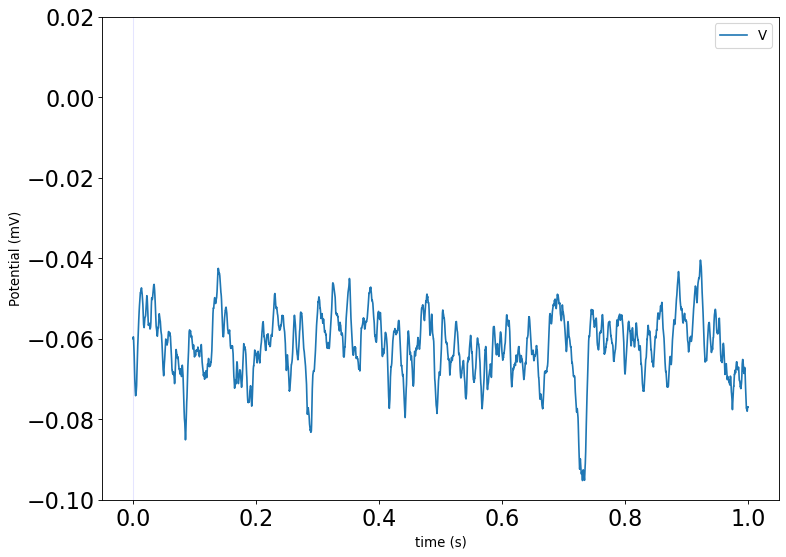

In [12]:
detailed_model = detailed(p_0)
detailed_model.run()
detailed_model.draw()

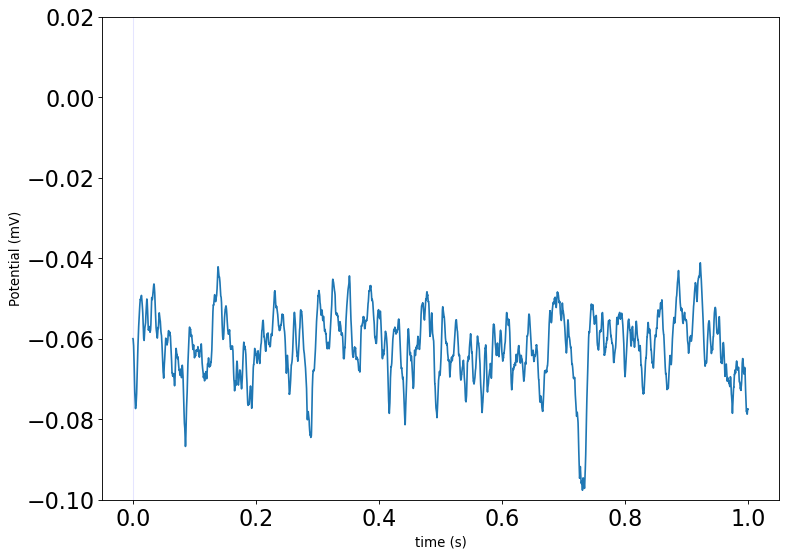

In [13]:
aeif_model = aEIF(p_0)
aeif_model.run()
aeif_model.draw()

## Comparison

In [14]:
V_detailed = detailed_model.extract_V()
V_aEIF = aeif_model.extract_V()

In [15]:
def compare(V_detailed,V_aEIF):
    start_time = 0
    end_time = start_time + p_0['t']
        
    fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 12})
    ax = plt.subplot(1,2,1)
    plt.subplots_adjust(hspace = 1)
    # Plot the potential
    plt.plot(np.arange(start_time, end_time,p_0['dt']), V_detailed, '--',label = 'Detailed model', color='r')
    plt.plot(np.arange(start_time, end_time,p_0['dt']), V_aEIF, label = 'aEIF model', color='g')
        # Plot the adaptation current
    axes = plt.gca()
    plt.xlabel('time (s)')
    plt.ylabel('Potential (mV)')
    plt.ylim(p_0['y_min'], p_0['y_max'])
        #plt.yticks(np.arange((self.parameters['y_min'] ) / 1000, (self.parameters['y_max'] ) / 1000, 0.02), 
        #           np.arange(self.parameters['y_min'], self.parameters['y_max'] , 20))
    plt.legend()
    plt.show()

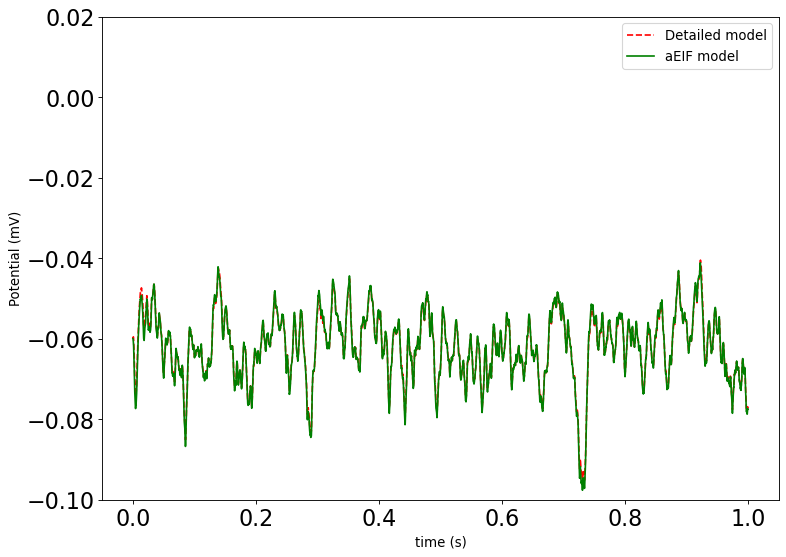

In [16]:
compare(V_detailed,V_aEIF)

Same thing for current pulses: 

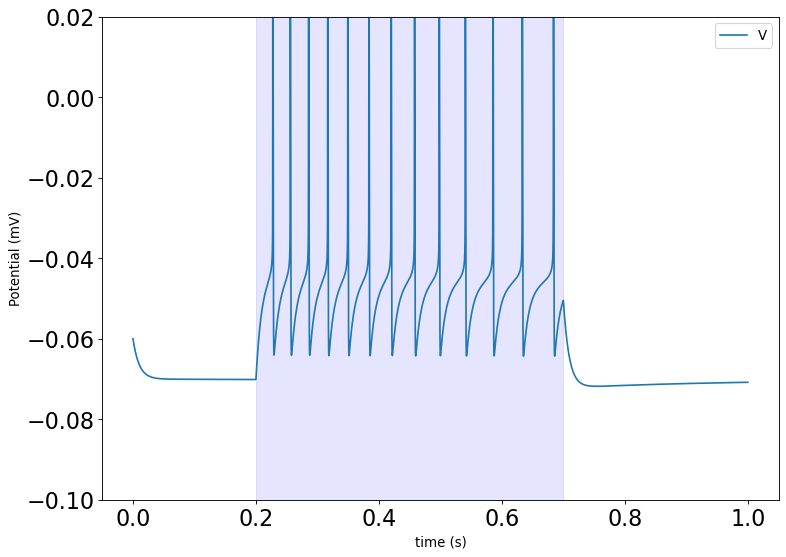

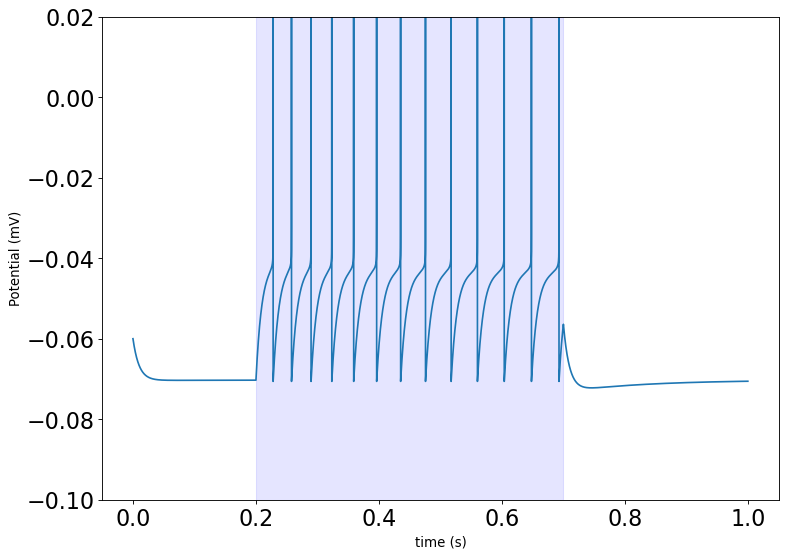

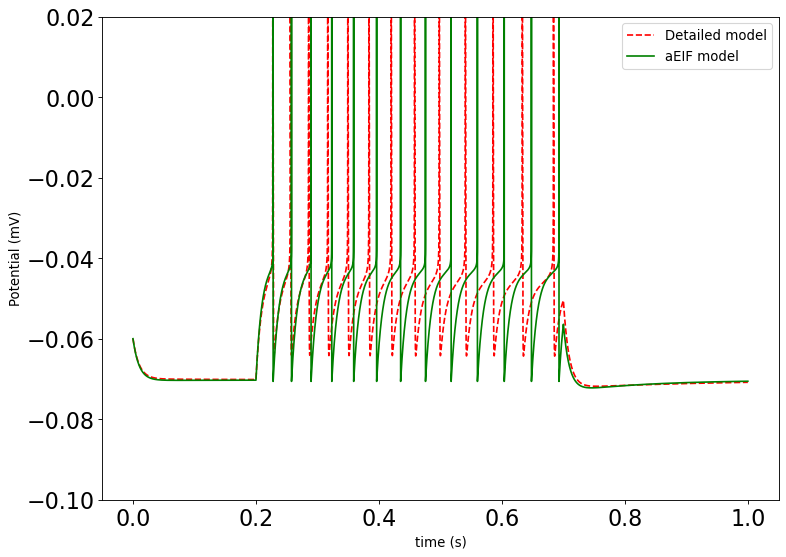

In [17]:
# Time
parameters.update({'dt': 0.05 * brian2.ms,
                   't' : 1000 * brian2.ms,})
parameters.update({'N': int(parameters['t']/parameters['dt'])})
    
# Initial Conditions
parameters.update({'V_0' : -60 * brian2.mV})

# Plotting 
parameters.update({'y_min' : -0.1,
                   'y_max' : 0.02})
    
# Ext. current
parameters.update({'stim_strength': 0.8 * (brian2.nA),
            'stim_on': 200* brian2.ms,
            'stim_off': 700 * brian2.ms,
            'syn_off' : 1,
            'ramp' : 0
                  })

conductances = g_paradigms['MC'][0]
parameters.update({
            'g_AMPA': conductances[0] * 30 * brian2.nS,
            'g_GABA': conductances[1] * 30 * brian2.nS,
            'sigma_AMPA': conductances[2] * 30 * brian2.nS,
            'sigma_GABA' : conductances[3] * 30 * brian2.nS
        })

parameters.update({'random_vect_AMPA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N']),
                   'random_vect_GABA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N'])
                    })

p_0 = parameters.copy()

detailed_model = detailed(p_0)
detailed_model.run()
detailed_model.draw()

aeif_model = aEIF(p_0)
aeif_model.run()
aeif_model.draw()

V_detailed = detailed_model.extract_V()
V_aEIF = aeif_model.extract_V()
compare(V_detailed,V_aEIF)

And now for a bunch of conductance paradigms : 
    

Plotting 2 random paradigms for LC


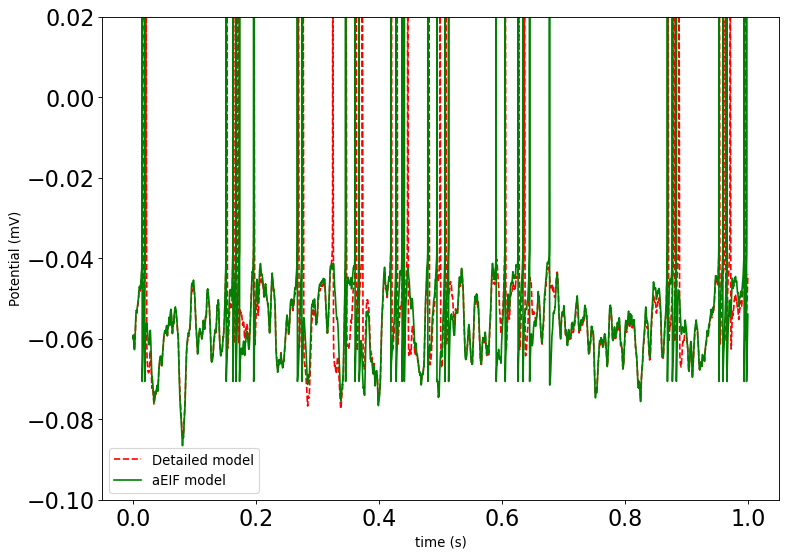

In [ ]:
# Time
parameters.update({'dt': 0.05 * brian2.ms,
                   't' : 1000 * brian2.ms,})
parameters.update({'N': int(parameters['t']/parameters['dt'])})

# Initial Conditions
parameters.update({'V_0' : -60 * brian2.mV})

# Plotting 
parameters.update({'y_min' : -0.1,
                   'y_max' : 0.02})

# Ext. current
parameters.update({'stim_strength': 0 * (brian2.nA),
            'stim_on': 0* brian2.ms,
            'stim_off': 0 * brian2.ms,
            'syn_off' : 0,
            'ramp' : 0
                  })

for paradigm in g_paradigms.keys():
    print('Plotting 2 random paradigms for {}'.format(paradigm))
    for _ in range(2):
        i = np.random.randint(5)

        conductances = g_paradigms[paradigm][i]
        parameters.update({
                    'g_AMPA': conductances[0] * 30 * brian2.nS,
                    'g_GABA': conductances[1] * 30 * brian2.nS,
                    'sigma_AMPA': conductances[2] * 30 * brian2.nS,
                    'sigma_GABA' : conductances[3] * 30 * brian2.nS
                })

        parameters.update({'random_vect_AMPA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N']),
                           'random_vect_GABA' : np.random.normal(loc=0.0,scale=1.0, size=parameters['N'])
                            })

        p_0 = parameters.copy()

        detailed_model = detailed(p_0)
        detailed_model.run()
        aeif_model = aEIF(p_0)
        aeif_model.run()

        V_detailed = detailed_model.extract_V()
        V_aEIF = aeif_model.extract_V()
        compare(V_detailed,V_aEIF)